# DSHC Assignment 2 - Titanic - prediction

## Description
1. Build training and testing dataset of assignment 1.
2. To predict the probability of a survival of a person based on 
    1. gender, 
    2. age, and 
    3. passenger-class.

### References:
1. [Titanic-EDA-Classify](https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv)
2. [Doc RFC](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
3. [Doc train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
4. [Doc model_evaluation()](https://scikit-learn.org/stable/modules/model_evaluation.html)
5. [Doc grid_search()](https://scikit-learn.org/stable/modules/grid_search.html)


Import required libraries
1. Data - load/manipulate/visualize
2. Modelling - split/train/evaluate/test/save
3. Extra

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from ipywidgets import widgets

In [2]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pickle
# !pip install pickleshare

Load the train and test dataset

In [5]:
df_titanic = pd.read_csv('../data/titanic/train.csv')
df_titanic_test_in = pd.read_csv('../data/titanic/test_in.csv')
df_titanic_test_out = pd.read_csv('../data/titanic/test_out.csv')

In [6]:
random_state = 1234

In [7]:
def print_df(df_titanic):
    print(f"rows/instances: {df_titanic.shape[0]}")
    print(f"\ncolumns/features: {df_titanic.shape[1]}")
    print(f"\ncolumn names: {df_titanic.columns}")
    print(f"\nTotal missing values: {df_titanic.isnull().values.sum()}")
    print(f"\nUnique values: \n{df_titanic.nunique()}")

In [8]:
df_titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
df_titanic_test_in.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
df_titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Clean the Dataset

In [11]:
def rename_cols_df_titanic(df):
    dict_rename_cols_titanic = {'PassengerId':'id_passenger', 'Survived': 'is_survived', 
                                'Pclass': 'class_passenger', 'Name': 'name_passenger', 
                                'Sex': 'gender', 'Age': 'age', 'SibSp': 'sib_sp',
                                'Parch': 'parch', 'Ticket': 'id_ticket', 'Fare':'num_fare', 
                                'Cabin': 'type_cabin', 'Embarked':'is_embarked'}
    df.rename(columns=dict_rename_cols_titanic, inplace=True)
    df.head()
    return df

Pre-processing steps to be applied to all the data 
1. Train
2. Eval
3. Test

In [12]:
df_titanic = rename_cols_df_titanic(df_titanic)
df_titanic_test_in = rename_cols_df_titanic(df_titanic_test_in)
df_titanic_test_out = rename_cols_df_titanic(df_titanic_test_out)

In [13]:
df_titanic.head()

,id_passenger,is_survived,class_passenger,name_passenger,gender,age,sib_sp,parch,id_ticket,num_fare,type_cabin,is_embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
df_titanic_test_out.head()

,id_passenger,is_survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [15]:
df_titanic_test_in.head()

,id_passenger,class_passenger,name_passenger,gender,age,sib_sp,parch,id_ticket,num_fare,type_cabin,is_embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [16]:
mean_age = round(df_titanic['age'].mean(), 2)
mean_age

29.7

In [17]:
def get_who(row):
    # print(row, type(row))
    str_who = ""
    age = row['age']
    gender = row['gender']
    if 0<age<=12:
        str_who += 'child'
    elif 12<age<=50:
        str_who +=  'adult'
    elif 50<age:
        str_who +=  'senior'
    
    str_who += '_' + gender
    return str_who


In [18]:
df_titanic['who'] = df_titanic.apply(lambda row: get_who(row), axis=1)
df_titanic.head()

,id_passenger,is_survived,class_passenger,name_passenger,gender,age,sib_sp,parch,id_ticket,num_fare,type_cabin,is_embarked,who
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,adult_male
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult_female
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,adult_female
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult_female
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult_male


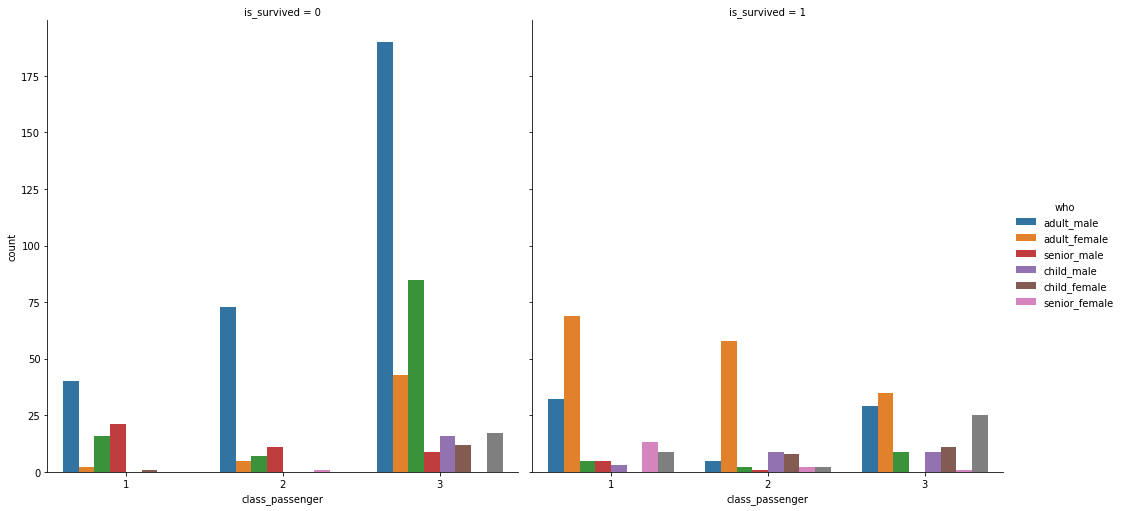

In [19]:
g = sns.catplot(x="class_passenger", hue="who", col="is_survived",
                data=df_titanic, kind="count",
                height=7);

In [20]:
print_df(df_titanic)

rows/instances: 891

columns/features: 13

column names: Index(['id_passenger', 'is_survived', 'class_passenger', 'name_passenger',
       'gender', 'age', 'sib_sp', 'parch', 'id_ticket', 'num_fare',
       'type_cabin', 'is_embarked', 'who'],
      dtype='object')

Total missing values: 866

Unique values: 
id_passenger       891
is_survived          2
class_passenger      3
name_passenger     891
gender               2
age                 88
sib_sp               7
parch                7
id_ticket          681
num_fare           248
type_cabin         147
is_embarked          3
who                  8
dtype: int64


Questions:
1. What are the operations being done here?
2. Why did I do dropna here?

In [21]:
def get_relevant_features(df, is_train=True):
    cols = ['gender', 'age', 'class_passenger']
    
    if is_train:
        cols += ['is_survived']
    
    cat_cols = ['gender', 'class_passenger']
    
    df_tmp = df[cols].copy()
    
    dict_na_values = {'age': mean_age}
    df_tmp = df_tmp.fillna(value=dict_na_values)
    df_tmp = df_tmp.dropna()
    df_tmp['class_passenger'] = df_tmp['class_passenger'].astype(str)
    
    for col in cat_cols:
        df_tmp[col] = df_tmp[col].astype('category')
    
    df_tmp = pd.get_dummies(df_tmp, columns=cat_cols)
    
    return df_tmp
    

Feature Engineering

In [22]:
col_target = 'is_survived'

df_train = get_relevant_features(df_titanic)
df_test = get_relevant_features(df_titanic_test_in, is_train=False)

y_train = list(df_train[col_target])
del df_train[col_target]

In [23]:
df_train.head()

,age,gender_female,gender_male,class_passenger_1,class_passenger_2,class_passenger_3
0,22.0,0,1,0,0,1
1,38.0,1,0,1,0,0
2,26.0,1,0,0,0,1
3,35.0,1,0,1,0,0
4,35.0,0,1,0,0,1


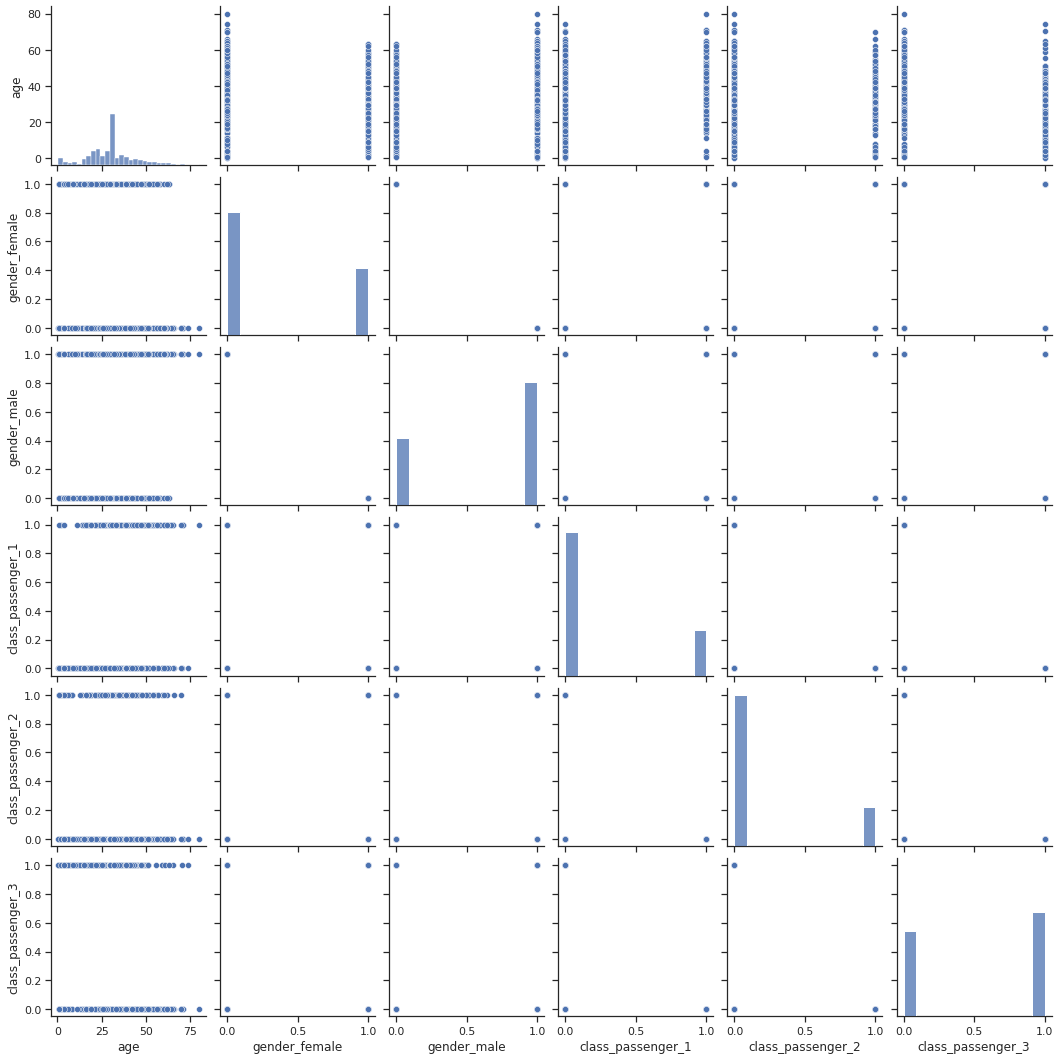

In [24]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df_train)

plt.show()

In [25]:
df_test.head()

,age,gender_female,gender_male,class_passenger_1,class_passenger_2,class_passenger_3
0,34.5,0,1,0,0,1
1,47.0,1,0,0,0,1
2,62.0,0,1,0,1,0
3,27.0,0,1,0,0,1
4,22.0,1,0,0,0,1


Hyper-parameter tuning

List of important steps:
1. Setup the train-test suite (Pipeline)
2. Set parameter search space/grid
5. Run Cross Validation for different models to select the best

In [26]:
train_x, eval_x, train_y, eval_y = train_test_split(df_train, y_train, test_size=0.3, random_state=random_state)

In [27]:
model_rfc = RandomForestClassifier(random_state=random_state)

In [28]:
dict_param_grid = { 
    'n_estimators': [x for x in range(100, 500, 10)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [x for x in range(3, 10, 1)],
    'criterion' :['gini', 'entropy']
}
dict_param_grid

{'n_estimators': [100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290,
  300,
  310,
  320,
  330,
  340,
  350,
  360,
  370,
  380,
  390,
  400,
  410,
  420,
  430,
  440,
  450,
  460,
  470,
  480,
  490],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [3, 4, 5, 6, 7, 8, 9],
 'criterion': ['gini', 'entropy']}

In [29]:
cv_rfc = GridSearchCV(estimator=model_rfc, param_grid=dict_param_grid, cv=5)

In [ ]:
cv_rfc.fit(train_x, train_y)

In [ ]:
cv_rfc.best_params_

In [ ]:
model_rfc_best = RandomForestClassifier(random_state=random_state, 
                                        max_features='auto', 
                                        n_estimators= 200, 
                                        max_depth=8, 
                                        criterion='gini')

In [ ]:
model_rfc_best.fit(train_x, train_y)

In [ ]:
pred_y = model_rfc_best.predict(eval_x)

In [ ]:
print(f"Accuracy: RandomForestClassifier on eval data: {round(accuracy_score(eval_y, pred_y)*100, 2)}%")

In [ ]:
def predict_id(model, list_ids):
    df_tmp = df_titanic_test_in[df_titanic_test_in['id_passenger'].isin(list_ids)]
    df_y = df_titanic_test_out[df_titanic_test_out['id_passenger'].isin(list_ids)]
    
    df_tmp = get_relevant_features(df_tmp, is_train=False)
    list_pred = list(model.predict(df_tmp))
    
    list_actual = list(df_y['is_survived']) 
    print(f"actual: {list_actual}")
    print(f"pred__: {list_pred}")
    

In [ ]:
list_ids = [x for x in range(900, 910)]
list_ids

In [ ]:
predict_id(model_rfc_best, list_ids)

In [ ]:
def load_model(file_path='./models/rfc.pkl'):
    with open(file_path, 'rb') as file_obj:
        model = pickle.load(file_obj)
    return model

def save_model(model, file_path='./models/rfc.pkl'):
    with open(file_path, 'wb') as file_obj:
        pickle.dump(model, file_obj)

In [ ]:
file_path='./models/rfc2.pkl'
save_model(model_rfc_best, file_path)
loaded_model = load_model(file_path)

predict_id(loaded_model, list_ids)

In [ ]:

for name, importance in zip(df_train.columns, model_rfc_best.feature_importances_):
    print(name, "=", importance)

features = df_train.columns
importances = model_rfc_best.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()